In [1]:
from netCDF4 import Dataset
import numpy as np
import warnings
dataset = Dataset('Martin_snapshot_spatial.nc')
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
def ncdump(nc_fid, verb=True):
    '''
    ncdump outputs dimensions, variables and their attribute information.
    The information is similar to that of NCAR's ncdump utility.
    ncdump requires a valid instance of Dataset.

    Parameters
    ----------
    nc_fid : netCDF4.Dataset
        A netCDF4 dateset object
    verb : Boolean
        whether or not nc_attrs, nc_dims, and nc_vars are printed

    Returns
    -------
    nc_attrs : list
        A Python list of the NetCDF file global attributes
    nc_dims : list
        A Python list of the NetCDF file dimensions
    nc_vars : list
        A Python list of the NetCDF file variables
    '''
    def print_ncattr(key):
        """
        Prints the NetCDF file attributes for a given key

        Parameters
        ----------
        key : unicode
            a valid netCDF4.Dataset.variables key
        """
        try:
            print("\t\ttype:", repr(nc_fid.variables[key].dtype))
            for ncattr in nc_fid.variables[key].ncattrs():
                print('\t\t%s:' % ncattr,\
                      repr(nc_fid.variables[key].getncattr(ncattr)))
        except KeyError:
            print ("\t\tWARNING: %s does not contain variable attributes" % key)

    # NetCDF global attributes
    nc_attrs = nc_fid.ncattrs()
    if verb:
        print("NetCDF Global Attributes:")
        for nc_attr in nc_attrs:
            print('\t%s:' % nc_attr, repr(nc_fid.getncattr(nc_attr)))
    nc_dims = [dim for dim in nc_fid.dimensions]  # list of nc dimensions
    # Dimension shape information.
    if verb:
        print("NetCDF dimension information:")
        for dim in nc_dims:
            print("\tName:", dim )
            print("\t\tsize:", len(nc_fid.dimensions[dim]))
            print_ncattr(dim)
    # Variable information.
    nc_vars = [var for var in nc_fid.variables]  # list of nc variables
    if verb:
        print("NetCDF variable information:")
        for var in nc_vars:
            if var not in nc_dims:
                print('\tName:', var)
                print("\t\tdimensions:", nc_fid.variables[var].dimensions)
                print("\t\tsize:", nc_fid.variables[var].size)
                print_ncattr(var)
    return nc_attrs, nc_dims, nc_vars

In [3]:
nc_attrs, nc_dims, nc_vars = ncdump(dataset)

NetCDF Global Attributes:
NetCDF dimension information:
	Name: longitude
		size: 127
	Name: latitude
		size: 254
	Name: depth
		size: 1
	Name: time
		size: 1
	Name: class
		size: 4
	Name: n_obs
		size: 24
NetCDF variable information:
	Name: lon
		dimensions: ('longitude', 'latitude')
		size: 32258
		type: dtype('float64')
		units: 'degrees_east'
		axis: 'X'
	Name: lat
		dimensions: ('longitude', 'latitude')
		size: 32258
		type: dtype('float64')
		units: 'degrees_north'
		axis: 'Y'
	Name: dpt
		dimensions: ('depth',)
		size: 1
		type: dtype('float64')
		units: 'm'
		axis: 'Z'
	Name: tim
		dimensions: ('time',)
		size: 1
		type: dtype('float64')
		units: 'days since 1950-01-01 00:00:00'
		axis: 'T'
	Name: temperature
		dimensions: ('longitude', 'latitude', 'depth', 'time')
		size: 32258
		type: dtype('float64')
		units: 'degC'
	Name: labels
		dimensions: ('longitude', 'latitude', 'time')
		size: 32258
		type: dtype('float64')
		long_name: 'Attributed class'
	Name: posteriors
		dimension

In [152]:
warnings.filterwarnings('ignore')

long = np.array(dataset['lon']) #Whole data longitudes
lat = np.array(dataset['lat']) #Whole data latitudes

lab = np.array(dataset['labels']) #Whole data classes
lab = np.reshape(lab, (127,254))

posteriors = dataset['posteriors'] #Whole data posteriors
posteriors = np.reshape(posteriors,(4,127,254))

obs_lon = dataset['obs_lon'] #Observations longtitudes
obs_lat = dataset['obs_lat'] #Observations latitudes

obs_ilon = np.array(dataset['obs_ilon']).astype(int) #Observations indices in "long"
obs_ilat = np.array(dataset['obs_ilat']).astype(int) #Observations indices in "lat"


class_obs = lab[obs_ilon,obs_ilat] #Observations classes

temp = np.reshape(dataset['temperature'],(127,254)) #Whole data temperature

colors = ['g','r','y','b'] #Colors used to display classes

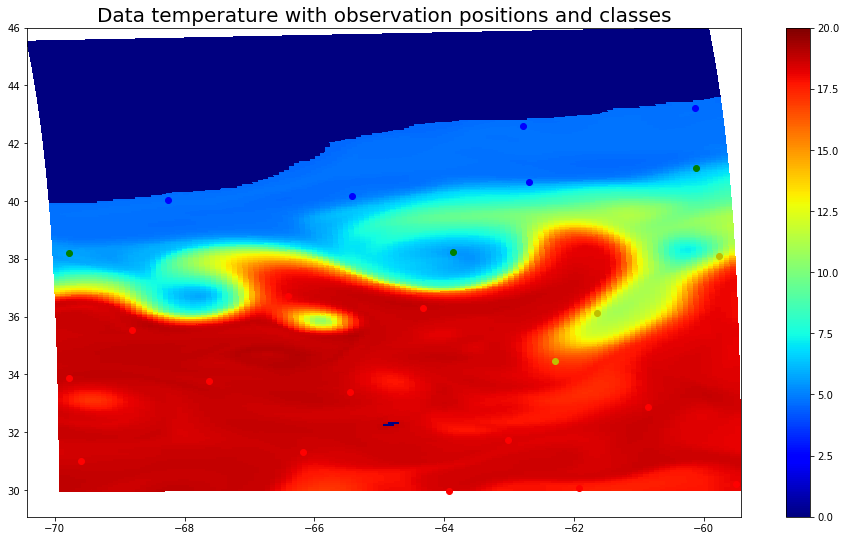

In [171]:
warnings.filterwarnings('ignore')
pylab.rcParams['figure.figsize'] = (16.0, 9.0)

fig, ax = subplots()
p = ax.pcolor(long , lat, temp, cmap=cm.jet, vmin=0, vmax=20)

ind_classes = [] #Array to store indices of observations grouped by class
for k in range(1,5):
    ind = np.where(class_obs == k)
    ind_classes.append(ind)
    scatter(obs_lon[ind], obs_lat[ind], color=colors[k-1])
title('Data temperature with observation positions and classes',fontsize=20)    
cb = fig.colorbar(p)

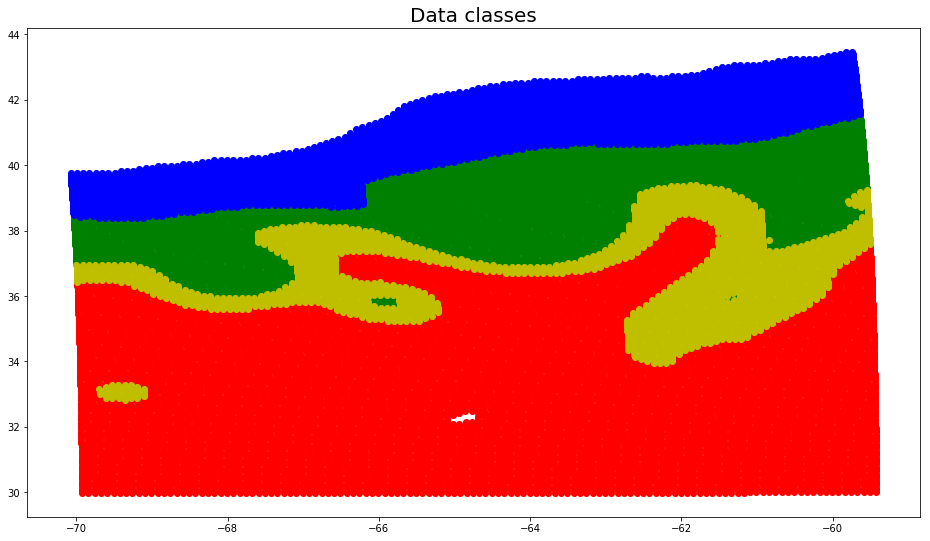

In [150]:
pylab.rcParams['figure.figsize'] = (16.0, 9.0)
title('Data classes',fontsize=20)   
for k in range(1,5):
    ind = np.where(lab == k)
    scatter(long[ind[0],ind[1]], lat[ind[0],ind[1]], color=colors[k-1])

In [139]:
from math import *

#geodesic distance in km
def dist_geo(long1, lat1, long2, lat2):
    try:
        value= sin(lat1*2*pi/360)*sin(lat2*2*pi/360) + cos(lat1*2*pi/360)*cos(lat2*2*pi/360)\
                    *cos((long2 - long1)*2*pi/360)
        return acos(min(1,value))*6378
    except ValueError:
        print(long1, lat1, long2, lat2,sin(lat1*2*pi/360)*sin(lat2*2*pi/360) + cos(lat1*2*pi/360)*cos(lat2*2*pi/360)\
                    *cos((long2 - long1)*2*pi/360))

vdist_geo = np.vectorize(dist_geo, excluded=['long1', 'lat1'])

def get_knearest(longs, lats, points, indices, k):
    distances = vdist_geo(longs, lats, points[:,0], points[:,1])
    s_distances, s_neigh = (np.array(t) for t in zip(*sorted(zip(distances, indices))))
    return s_distances[:k], s_neigh[:k]


def alpha(distances, i, coeff):
    return exp(-distances[i]/coeff)/sum(np.exp(-np.array(distances)/coeff))

def valpha(distances, coeff):
    l = len(distances)
    alphas = np.zeros((l,))
    for i in range(l):
        alphas[i] = alpha(distances, i, coeff)
    return alphas


In [83]:
pts_classes = lab[obs_ilon, obs_ilat].astype(int)

grouped_by_class = [[],[],[],[]]
for l in range(len(obs_lon)):
    c = pts_classes[l] - 1
    grouped_by_class[c].append(np.concatenate(([obs_lon[l]], [obs_lat[l]], [obs_ilon[l]], [obs_ilat[l]], [l])))
for t in range(4):
    grouped_by_class[t] = np.array(grouped_by_class[t])


In [167]:
import copy
warnings.filterwarnings('ignore')
k = 4
coeff = 50
coeff2 = 400

bad_temp = np.zeros((127,254))
good_temp = np.zeros((127,254))
very_good_temp = np.zeros((127,254))
est_post = np.zeros((4,127,254))
est_lab = np.zeros((127,254))
gaus_mean = np.array([7.70938140771444, 18.5364702094555, 15.4116575244064, 4.702268415742165])
for i in range(127):
    for j in range(254):
        if np.isnan(lab[i,j]) == False:
            lon = long[i,j]
            lati = lat[i,j]
            distances, knearest = get_knearest(lon, lati, np.column_stack((obs_lon, obs_lat)),\
                                               np.column_stack((obs_ilon, obs_ilat)), k)
            
            alphas = valpha(distances, coeff)
            bad_temp[i,j] = sum(alphas*temp[knearest[:,0],knearest[:,1]])
            est_post[:,i,j] = alphas.dot(np.transpose(posteriors[:,knearest[:,0],knearest[:,1]]))
            est_lab[i,j] = np.argmax(est_post[:,i,j]) + 1
            good_temp[i,j] = sum(est_post[:,i,j]*gaus_mean)  
    
 
            loc_means = copy.copy(gaus_mean)
            for t in range(4):
                if grouped_by_class[t] != []:
                    coord_lon = grouped_by_class[t][:,0]
                    coord_lat = grouped_by_class[t][:,1]
                    ind_lon = grouped_by_class[t][:,2].astype(int)
                    ind_lat = grouped_by_class[t][:,3].astype(int)
                    
                    distances = vdist_geo(lon, lati, coord_lon, coord_lat)
                    alphas = valpha(distances, coeff2)
                    loc_means[t] = sum(alphas*temp[ind_lon, ind_lat])
                    
            very_good_temp[i,j] = sum(est_post[:,i,j]*loc_means)

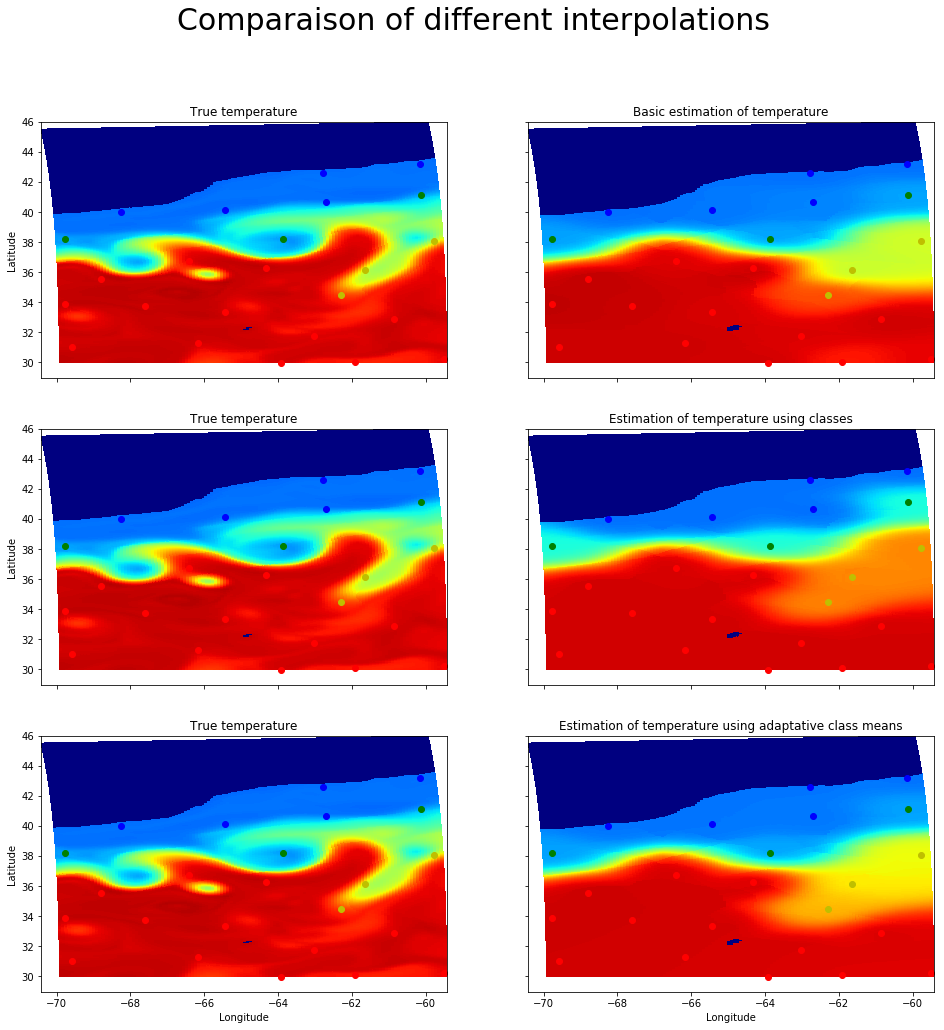

In [168]:
pylab.rcParams['figure.figsize'] = (16,16)
warnings.filterwarnings('ignore')

titles = ['Basic estimation of temperature', 'Estimation of temperature using classes',\
         'Estimation of temperature using adaptative class means']
all_temp = [bad_temp, good_temp, very_good_temp]

f, axarr = plt.subplots(3, 2, sharex='col', sharey='row')
for k in range(3):
    p = axarr[k,0].pcolor(long, lat, temp, cmap=cm.jet, vmin=0, vmax=20)
    axarr[k,0].set_title('True temperature')
    axarr[k,0].set_ylabel('Latitude')
    p = axarr[k,1].pcolor(long, lat, all_temp[k], cmap=cm.jet, vmin=0, vmax=20)
    axarr[k,1].set_title(titles[k])

for k in range(1,5):
    ind = np.where(class_obs == k)
    for i in range(3):
        for j in range(2):
            p = axarr[i,j].scatter(obs_lon[ind], obs_lat[ind], color=colors[k-1])
axarr[2,0].set_xlabel('Longitude')
axarr[2,1].set_xlabel('Longitude')
f.suptitle('Comparaison of different interpolations',fontsize=30)

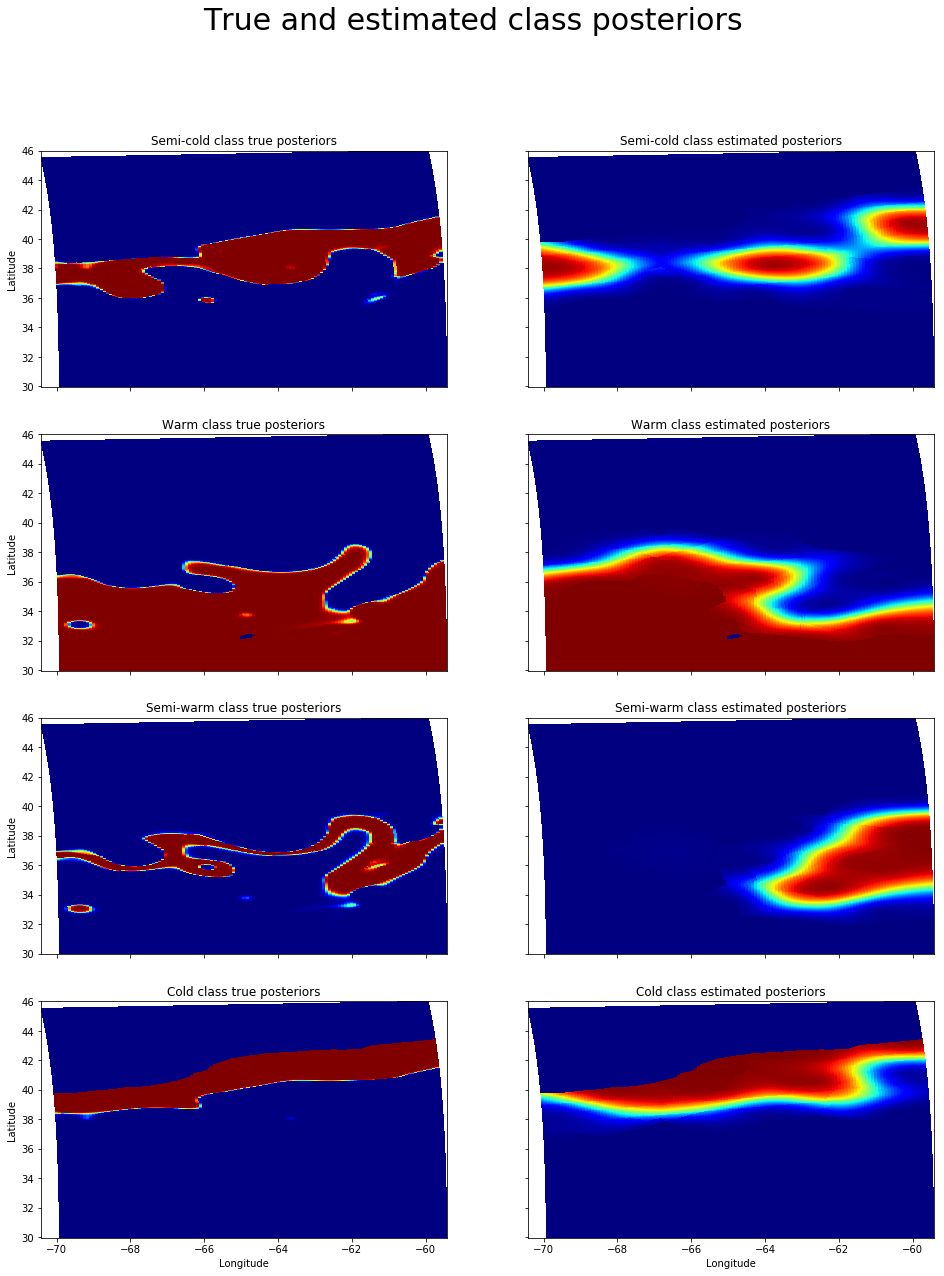

In [169]:
pylab.rcParams['figure.figsize'] = (16.0, 20)
warnings.filterwarnings('ignore')

left_titles = ['Semi-cold class true posteriors','Warm class true posteriors', 'Semi-warm class true posteriors', \
       'Cold class true posteriors']
right_titles = ['Semi-cold class estimated posteriors','Warm class estimated posteriors', \
              'Semi-warm class estimated posteriors', 'Cold class estimated posteriors']

f, axarr = plt.subplots(4, 2, sharex='col', sharey='row')
for k in range(4):
    p = axarr[k,0].pcolor(long, lat, posteriors[k,:,:], cmap=cm.jet, vmin=0, vmax=1)
    axarr[k,0].set_ylabel('Latitude')
    axarr[k,0].set_title(left_titles[k])
    axarr[k,1].set_title(right_titles[k])
    p = axarr[k,1].pcolor(long, lat, est_post[k,:,:], cmap=cm.jet, vmin=0, vmax=1)
axarr[3,0].set_xlabel('Longitude')
axarr[3,1].set_xlabel('Longitude')
f.suptitle('True and estimated class posteriors', fontsize=30)

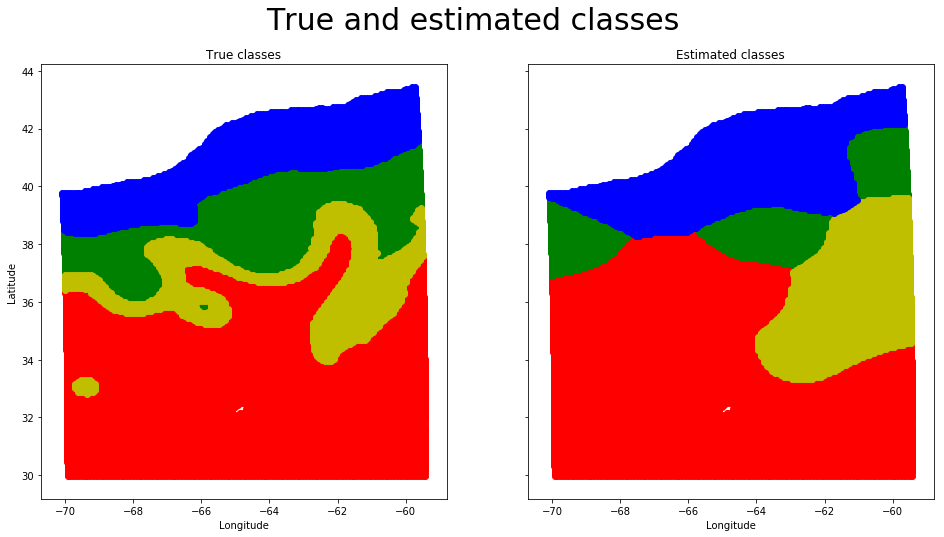

In [170]:
pylab.rcParams['figure.figsize'] = (16, 8)

f, (ax1, ax2) = plt.subplots(1, 2, sharex='col', sharey='row')
for k in range(1,5):
    ind1 = np.where(lab == k)
    ind2 = np.where(est_lab == k)
    p = ax1.scatter(long[ind1[0],ind1[1]], lat[ind1[0],ind1[1]], color=colors[k-1])
    ax1.set_title('True classes')
    p = ax2.scatter(long[ind2[0],ind2[1]], lat[ind2[0],ind2[1]], color=colors[k-1])
    ax2.set_title('Estimated classes')
    ax1.set_xlabel('Longitude')
    ax2.set_xlabel('Longitude')
    ax1.set_ylabel('Latitude')
    f.suptitle('True and estimated classes', fontsize=30)